# 単位円盤上のPoisson方程式


<img src="naburaFACE02.bmp" width="150" height="100">

[なぶら](https://twitter.com/nabla_ocbkansai)です。MathWork様の以下の[問題](https://jp.mathworks.com/help/pde/ug/solve-poissons-equation-on-a-unit-disk.html)が面白そうだったのでGetFEM++で解いてみます。円盤の半径は1.0で、円盤内ではPoisson方程式が成り立っているとします。円の境界にはDirichlet条件が設けられています。(画像はMathWorks様より引用)
![Geometory](https://jp.mathworks.com/help/examples/pde/win64/pdedemo1_01.png)

この問題の理論解は次式で表されます。

$$
u(x, y) = \dfrac{1-x^2-y^2}{4}
$$

GetFEM++でこの理論解と同じ結果が得られるのでしょうか。GetFEM++をインポートして解析をはじめましょう！

In [1]:
import getfem as gf

GetFEM++ではまず、MesherObjectでジオメトリを設定します。今回は中心が(0, 0)の半径1.0の円が必要です。ただ、このメッシュ生成の際には負の座標でメッシュを作成することが仕様上できません。とりあえず、中心が(1.0, 1.0)で半径が1.0の円を作成します。

In [2]:
mo = gf.MesherObject('ball', [1.0, 1.0], 1.0)

MesherObjectについて詳しく知りたい方は以下のコマンドを実行してください。使い方が表示されます。

In [3]:
gf.MesherObject?

次にメッシュの作成を行います。MathWorks様のサイトを見ると、長さ1あたり約10分割されていますね。そこで、Meshオブジェクトのgenerate機能でメッシュのおおよその直径hを0.1としてメッシュを作成します。今回の解析では2次要素を用いるためコマンドは次のようになります。

In [4]:
h = 0.1
mesh = gf.Mesh('generate', mo, h, 2)
gf.Mesh?

これでメッシュができました。実際にメッシュを表示させてみましょう。ここではmayaviというライブラリを使って画像をJupyter上に表示させています。ただ、ここの部分は今回の話の本質ではないので、解説は省略しますね。今度機会があれば説明しますね。とりあえずこうすれば結果が表示できるんだぐらいに思っておいてください。

Notebook initialized with x3d backend.


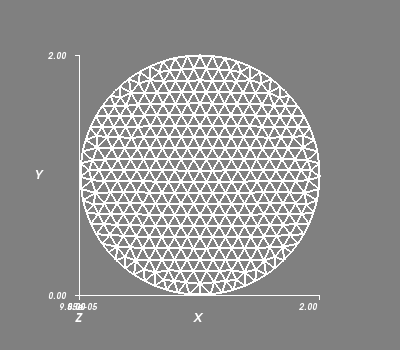

In [5]:
filename = 'mesh.vtk'
mesh.export_to_vtk(filename, 'ascii')

from mayavi import mlab
mlab.init_notebook()
vtk_file_reader = mlab.pipeline.open(filename)
extract_edges = mlab.pipeline.extract_edges(vtk_file_reader)
surface = mlab.pipeline.surface(extract_edges)
axes = mlab.axes(surface)

picturename = 'mesh.png'
mlab.show()
mlab.savefig(picturename)
mlab.clf()
from IPython.display import Image, display_png
display_png(Image(picturename))

メッシュきれいにできていますね！間隔も問題なさそうです。でもあれ？中心が(1.0, 1.0)になっている・・・



<img src="naburaFACE03.bmp" width="150" height="100">



そうだ！中心を(1.0, 1.0)にして後でシフトするんでしたよね。

メッシュをベクトル表示で(-1.0, -1.0)の方向にシフトさせましょう。その際には以下のコマンドを実行します。

In [6]:
mesh.translate([-1.0, -1.0])

再度表示を指せると。。。今度は中心が(0.0, 0.0)になりましたね。よかった。

Notebook initialized with x3d backend.


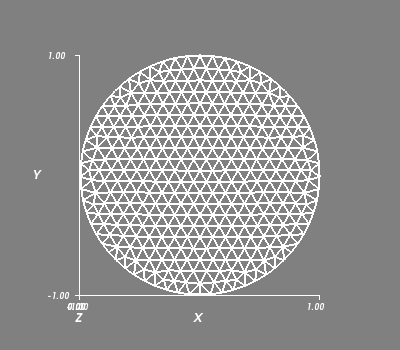

In [7]:
filename = 'mesh.vtk'
mesh.export_to_vtk(filename, 'ascii')

from mayavi import mlab
mlab.init_notebook()
vtk_file_reader = mlab.pipeline.open(filename)
extract_edges = mlab.pipeline.extract_edges(vtk_file_reader)
surface = mlab.pipeline.surface(extract_edges)
axes = mlab.axes(surface)

picturename = 'mesh.png'
mlab.show()
mlab.savefig(picturename)
mlab.clf()
from IPython.display import Image, display_png
display_png(Image(picturename))

さて、このメッシュの外側の境界にはDirichlet条件を設定する必要があります。そのためにouter_facesメソッドでメッシュの外側の面を抽出し、set_regionメソッドで領域を設定しておきます。

In [8]:
fb = mesh.outer_faces()
OUTER_BOUND = 1
mesh.set_region(OUTER_BOUND, fb)

次にメッシュに有限要素法を割り当てるオブジェクトMeshFEMを作成します。今回は通常のLagrange要素を使用します。節点の自由度は1、要素次数は2とします。

In [9]:
mfu = gf.MeshFem(mesh, 1)

elements_degree = 2
mfu.set_classical_fem(elements_degree)



<img src="naburaFACE05.bmp" width="150" height="100">


MeshFEMオブジェクトの用意ができましたので、問題を解くためのModelオブジェクトを作成します。変数uとしてmfuを設定します。ここいらへんが一番難しいところです、半分まで来ていますのでファイトです。

有限要素法で問題を解く際には以下のような連立方程式を解きます。Modelオブジェクトはこの連立方程式を管理してくれるオブジェクトです。

<img src="http://getfem.org/_images/getfemuserlinearsys.png" width="600" height="400">


実際にモデルオブジェクトを定義してみましょう。今回は実数モデルですので、'real'を引数にしてModelオブジェクトmdを作成します。

In [10]:
md = gf.Model('real')
md.add_fem_variable('u', mfu)

次に円$\Omega$上で以下の微分方程式を仮定します。
$$
-\Delta u = 1, u \subset \Omega
$$
この形の微分方程式を追加する際には'add_Laplacian_brick'というメソッドを使用します。詳しくは md.add_Laplacian_brick? で確認してみてください。

In [11]:
mim = gf.MeshIm(mesh, pow(elements_degree,2))
md.add_Laplacian_brick(mim, 'u')
md.add_Laplacian_brick?

これで先程の図の(unknown)部分に該当する'u'に対して(matrix of the system)にLaplacianのbrickが追加されたことになります。カンのいい人は気づいたかもしれませんが、(rhs)と書かれている部分についても設定をする必要があります。(matrix of the system)と(rhs)が決まらなければ連立方程式は解けないのです。微分方程式の右辺に1.0を加える際には以下のように設定を行います。

In [12]:
import numpy as np
md.add_fem_data('F', mfu)
md.add_source_term_brick(mim, 'u', 'F')
md.set_variable('F', np.repeat(1.0, mfu.nbdof()))

次にDirichlet境界条件の設定を行います。その際には先程設定した外側の境界部分OUTER_BOUNDを使用します。

In [13]:
md.add_Dirichlet_condition_with_multipliers(mim, 'u', elements_degree - 1, OUTER_BOUND)
md.add_Dirichlet_condition_with_multipliers?

Modelオブジェクトmdが完成しました。ここまでくればあとはsolveメソッドで解を計算することができます。

In [14]:
md.solve()

(0, 1)



<img src="naburaFACE02.bmp" width="150" height="100">


ついに問題を解くことができました! 先程の'u'が計算されたのです。'u'をプロットして計算結果を表示させてみましょう。

モデルオブジェクトmdから'u'を出力するには次のメソッドを使用します。

In [15]:
U = md.variable('u')

結果を出力するときには、MeshFEMオブジェクトを使用してMeshオブジェクトと同じように結果を画像出力できます。ここについてもこのようにすれば画像が出力できるのだと思っておいてください。

In [16]:
vtkfilename = 'displacement.vtk'
mfu.export_to_vtk(vtkfilename, mfu, U, 'Displacement')

Notebook initialized with x3d backend.


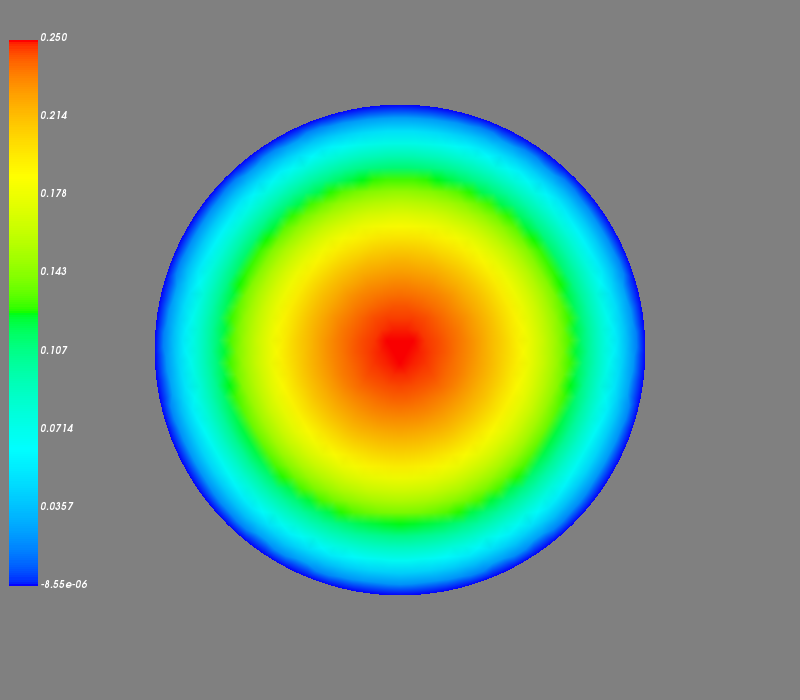

In [17]:
# mayavi2 -d displacement_with_von_mises1.vtk -f WarpVector -m Surface -d displacement_with_von_mises2.vtk -f WarpVector -m Surface
from mayavi import mlab

filename = 'solutions.png'

#%gui qt
mlab.init_notebook()
vtk_file_reader = mlab.pipeline.open(vtkfilename)
surface = mlab.pipeline.surface(vtk_file_reader)

mlab.scalarbar(orientation='vertical')
mlab.show()
mlab.savefig(filename, magnification=2)
mlab.clf()

from IPython.display import Image, display_png
display_png(Image(filename))

やりました!きれいな計算結果が出ていますね。でも結果を出力するだけで満足してはいけません。理論解との誤差を計算してみましょう。

今回の場合、理論解は次式で表されます。
$$
u(x, y) = \dfrac{1-x^2-y^2}{4}
$$

さて、mfu_uオブジェクトはbasic_dof_nodesメソッドを使うことで各自由度の座標値(x, y)を計算することができます。

In [18]:
xy = mfu.basic_dof_nodes()
x = xy[0, :]
y = xy[1, :]



<img src="naburaFACE06.bmp" width="150" height="100">


式の通りに計算したものを変数solに代入し'u'のときにと同様に画像出力してみます。

Notebook initialized with x3d backend.


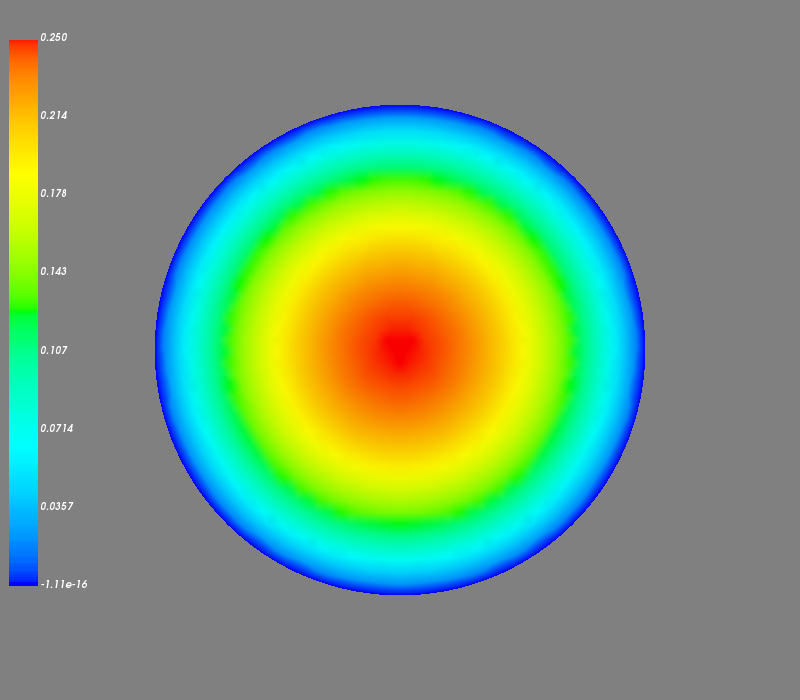

In [19]:
sol = (1-x*x-y*y)/4.0

vtkfilename = 'sol.vtk'
mfu.export_to_vtk(vtkfilename, mfu, sol, 'solution')

# mayavi2 -d displacement_with_von_mises1.vtk -f WarpVector -m Surface -d displacement_with_von_mises2.vtk -f WarpVector -m Surface
from mayavi import mlab

filename = 'solutions.png'

#%gui qt
mlab.init_notebook()
vtk_file_reader = mlab.pipeline.open(vtkfilename)
surface = mlab.pipeline.surface(vtk_file_reader)

mlab.scalarbar(orientation='vertical')
mlab.show()
mlab.savefig(filename, magnification=2)
mlab.clf()

from IPython.display import Image, display_png
display_png(Image(filename))

おおー。最大値も一致していますし、コンターも同じですから問題なさそうですね。でも念の為、計算結果Uと理論解solの誤差を計算しそれについても確認しておきましょう。

Notebook initialized with x3d backend.


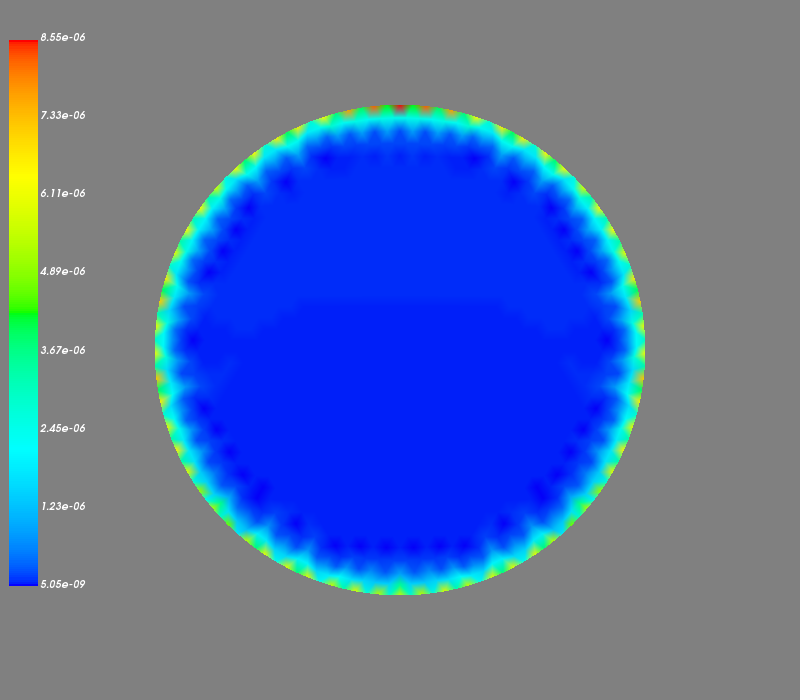

In [20]:
vtkfilename = 'error.vtk'
mfu.export_to_vtk(vtkfilename, mfu, np.abs(U-sol), 'error')

# mayavi2 -d displacement_with_von_mises1.vtk -f WarpVector -m Surface -d displacement_with_von_mises2.vtk -f WarpVector -m Surface
from mayavi import mlab

filename = 'solutions.png'

#%gui qt
mlab.init_notebook()
vtk_file_reader = mlab.pipeline.open(vtkfilename)
surface = mlab.pipeline.surface(vtk_file_reader)

mlab.scalarbar(orientation='vertical')
mlab.show()
mlab.savefig(filename, magnification=2)
mlab.clf()

from IPython.display import Image, display_png
display_png(Image(filename))



<img src="naburaFACE04.bmp" width="150" height="100">

誤差のオーダーはMathWorks様と同じですね。問題なさそうです！この計算が参考になればうれしいです。ではまた。

【なぶらちゃんキャラクターライセンスについて】

・キャラクターについて
「なぶらちゃん」キャラクターに関する著作権およびその他の一切の権利はオープンCAE勉強会＠関西に帰属します。
二次創作にあたり、著作権およびその他一切の権利を放棄・譲渡するものではありません。

【なぶらちゃん着せ替えセットについて】
・個人・サークルによる利用
非商用及びイベント等でのグッズ・同人誌の頒布等は、特にご連絡なくご利用いただけます。
利用の際は「オープンCAE勉強会＠関西」およびキャラ製作者の「キノ子(@donkinoko)」を表示ください。

・法人利用・商用利用
法人利用・商用利用の際は個別にお問い合わせください。

・禁止事項
「なぶらちゃん」以外のキャラクターとしての使用
キャラクターのイメージを著しく損なうような使用
法令および公序良俗に反するような使用
宗教、政治活動などへの使用

・その他
お気軽にお問い合わせください
ocb.kansai@gmail.com